In [1]:
import gymnasium as gym
import numpy as np
from collections import namedtuple, deque
import random
import matplotlib.pylab as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [1]:
class DQNAgent:

    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory_size =100_000
        self.discount = 0.95    # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.learning_rate = 0.001
        self.update_interval = 4
        self.optimizer = Adam(learning_rate = self.learning_rate)
        self.q_network= self._build_network()
        self.target_q_network = self._build_network()
        self.temperature = 10.0  # initial temperature
        self.min_temperature = 0.1  # minimum temperature
        self.temperature_decay = 0.95  # temperature decay rate
        
    
    def _build_network(self):
        # Build a simple neural network for Q-learning
        model = Sequential()
        model.add(Input(shape=(self.state_size,)))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        return model

    def evaluate_loss(self, experiences):
        # Calculate the loss
        states, actions, rewards, next_states, done_flags = experiences
        
        # Compute Q-values for the next states
        q_next = self.target_q_network(next_states)
        max_q_next = tf.math.reduce_max(q_next, axis=1)
        expected_q_values = rewards + self.discount * (1 - done_flags) * max_q_next

        # Get the Q-values for the current states and selected actions
        q_values = self.q_network(states)
        action_indices = tf.range(0, tf.shape(q_values)[0]) * tf.shape(q_values)[1] + tf.cast(actions, tf.int32)
        relevant_q_values = tf.gather(tf.reshape(q_values, [-1]), action_indices)

        loss_value = tf.reduce_mean(tf.square(expected_q_values - relevant_q_values))
        return loss_value

    def update_target_network(self):
        # Update the target Q-network
        update_factor = 0.001
        target_params = self.target_q_network.weights
        main_params = self.q_network.weights

        for target, main in zip(target_params, main_params):
            updated_weights = update_factor * main + (1 - update_factor) * target
            target.assign(updated_weights)
            
    @tf.function
    def agent_learn(self, experiences):
        # Perform a single learning step using gradient tape
        with tf.GradientTape() as tape:
            loss = self.evaluate_loss(experiences)
        parameters = self.q_network.trainable_variables
        gradients = tape.gradient(loss, self.q_network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, parameters))
        self.update_target_network()

    def select_action_softmax(self,state):
        #Softmax Method
        q_values = self.q_network(state).numpy()[0]
        q_values_adjusted = q_values / self.temperature
        q_values_max = np.max(q_values_adjusted)
        exp_q_values = np.exp(q_values_adjusted - q_values_max)
        prob_weights = exp_q_values / np.sum(exp_q_values)
        action = np.random.choice(range(self.action_size), p=prob_weights)
        return action
    
    def update_temperature(self):
        # Update the temperature for softmax action selection
        self.temperature = max(self.min_temperature, self.temperature * self.temperature_decay)

    
    def fetch_sampled_experiences(self, experience_buffer):
        sampled_experiences = random.sample(experience_buffer, k=64)
        state_list = [exp.state for exp in sampled_experiences if exp is not None]
        action_list = [exp.action for exp in sampled_experiences if exp is not None]
        reward_list = [exp.reward for exp in sampled_experiences if exp is not None]
        next_state_list = [exp.next_state for exp in sampled_experiences if exp is not None]
        done_list = [exp.terminated for exp in sampled_experiences if exp is not None]

        # Convert lists to TensorFlow tensors
        states_tensor = tf.convert_to_tensor(state_list, dtype=tf.float32)
        actions_tensor = tf.convert_to_tensor(action_list, dtype=tf.float32)
        rewards_tensor = tf.convert_to_tensor(reward_list, dtype=tf.float32)
        next_states_tensor = tf.convert_to_tensor(next_state_list, dtype=tf.float32)
        done_tensor = tf.convert_to_tensor(np.array(done_list).astype(np.uint8), dtype=tf.float32)

        return states_tensor, actions_tensor, rewards_tensor, next_states_tensor, done_tensor

    def get_one_hot_encoding(self, state):
        state_vector = np.zeros(self.state_size)
        state_vector[state] = 1
        
        return state_vector

NameError: name 'tf' is not defined

In [3]:
def Train_Agent(Agent, episodes, rewards, state_size):
    memory_buffer = deque(maxlen=Agent.memory_size)# Create a replay memory buffer using deque
    Agent.target_q_network.set_weights(Agent.q_network.get_weights())# Initialize the target Q-network weights
    
    # Parameters
    min_epsilon=0.01
    e_decay=0.05
    
    # Store the total rewards for each episode
    points_history = []
    time_step = 1000
    
    # Define the experience tuple for storing agent experiences
    experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "terminated"])
     
    for i in range(episodes):
        observation = env.reset()
        state = observation[0]
        state = Agent.get_one_hot_encoding(state)
        total_rewards = 0
        timesup = False
        step = 0
          
        while not timesup:
            state_qn = np.reshape(state, [1, state_size])# Reshape the state
            
            # Select an action using softmax exploration
            action=Agent.select_action_softmax(state_qn)
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_state = Agent.get_one_hot_encoding(next_state)
            
            # Store the experience in the replay memory
            memory_buffer.append(experience(state, action, reward, next_state, terminated))
            
            # Update the Q-network
            if (step+1) % Agent.update_interval == 0 and len(memory_buffer) > 64:
                experiences = Agent.fetch_sampled_experiences(memory_buffer)
                Agent.agent_learn(experiences)
            
            state = next_state
            total_rewards += reward
            step += 1
            
            if step == time_step:
                timesup = True

            if terminated:
                break

        points_history.append(total_rewards)
        avg_points = np.mean(points_history[-100:])

        # Update the temperature for softmax action selection
        Agent.update_temperature()

        print(f"\rEpisode {i+1} | Total point average of the last {100} episodes: {avg_points:.2f}", end="")


        if(avg_points >= 8):
            print(f"\rEnvironment solved in {i+1} episodes!")
            break
            
        if (i+1) % 100 == 0:
            print(f"\rEpisode {i+1} | Total point average of the last {100} episodes: {avg_points:.2f}")
        rewards.append(total_rewards)
        
    env.close()
    print(f"\rTraining completed over {episodes} episodes")
    



Episode 100 | Total point average of the last 100 episodes: -686.11
Episode 200 | Total point average of the last 100 episodes: -52.193
Episode 300 | Total point average of the last 100 episodes: -14.16
Episode 400 | Total point average of the last 100 episodes: -6.510
Episode 500 | Total point average of the last 100 episodes: -10.28
Episode 600 | Total point average of the last 100 episodes: 2.5135
Episode 700 | Total point average of the last 100 episodes: 4.81
Episode 800 | Total point average of the last 100 episodes: 6.97
Episode 900 | Total point average of the last 100 episodes: 5.44
Episode 1000 | Total point average of the last 100 episodes: 6.72
Episode 1100 | Total point average of the last 100 episodes: 7.60
Episode 1152 | Total point average of the last 100 episodes: 8.03Environment solved in 1152 episodes!
Training completed over 3000 episodes


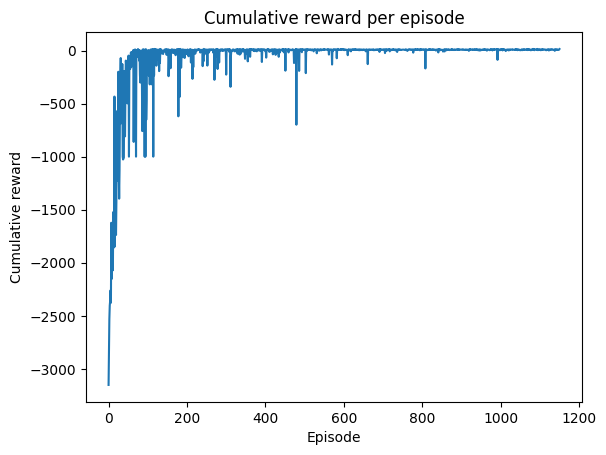

In [4]:
tf.random.set_seed(0)
env = gym.make('Taxi-v3')
env.reset()
rewards = []
episodes=3000
state_size = env.observation_space.n
action_size = env.action_space.n
Agent=DQNAgent(state_size, action_size)
Train_Agent(Agent, episodes, rewards, state_size)

# Plot the cumulative reward per episode
plt.title("Cumulative reward per episode")
plt.xlabel("Episode")
plt.ylabel("Cumulative reward")
plt.plot(rewards)
plt.show()
env.close()